In [1]:
%cd ComputerVisionProject/

/home/group.kurse/cviwo012/ComputerVisionProject


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [12]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from tqdm import tqdm
import os
import json

from CellDataset import CellDataset
from MoCoResNetBackbone import MoCoResNetBackbone

In [13]:
# ========== Configuration ==========
checkpoint_path = Path("/scratch/cv-course-group-5/models/training1/model_epoch40.pth")  # adjust if needed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
# save_path = Path("embeddings_cells.npz")

In [14]:
_json_path = Path('train_test_split.json')

# Load the file
with open(_json_path, 'r') as f:
    _split_data = json.load(f)

# Access the train and test entries
train_list = _split_data.get("train", [])
test_list = _split_data.get("test", [])
val_list = _split_data.get("val", [])

In [15]:
# ========== Load model ==========
model = MoCoResNetBackbone()
model.to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# ========== Prepare dataset ==========
dataset = CellDataset(video_list=test_list[:10], mode='inference')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

38488


In [17]:
all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(dataloader, desc="Extracting embeddings"):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.cpu().numpy()  # optional, if tensor
        embeddings = model.encode_query(imgs)  # → (B, 2048)
        embeddings = embeddings.cpu().numpy()

        all_embeddings.append(embeddings)
        all_labels.append(labels)

Extracting embeddings: 100%|██████████████████████████████████████████████████████████| 602/602 [00:26<00:00, 23.00it/s]


In [18]:
embeddings = np.concatenate(all_embeddings, axis=0)
labels = np.concatenate(all_labels, axis=0)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [ ]:
# === Dimensionality reduction methods ===
reducers = {
    "PCA": PCA(n_components=2),
    "t-SNE": TSNE(n_components=2, perplexity=30, random_state=42),
    "UMAP": umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
}

reduced_results = {}

for name, reducer in reducers.items():
    print(f"Running {name}...")
    reduced_results[name] = reducer.fit_transform(embeddings)

Running PCA...
Running t-SNE...
Running UMAP...


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [20]:
reducers = {
    # --- PCA ---
    "PCA_2": PCA(n_components=2),

    # --- t-SNE ---
    "tSNE_perp10": TSNE(n_components=2, perplexity=10, n_iter=1500, learning_rate=300, init="pca", metric="euclidean", random_state=42),
    "tSNE_perp30": TSNE(n_components=2, perplexity=30, n_iter=1500, learning_rate=300, init="pca", metric="euclidean", random_state=42),
    "tSNE_perp50_cosine": TSNE(n_components=2, perplexity=50, n_iter=1500, learning_rate=300, init="pca", metric="cosine", random_state=42),

    # --- UMAP ---
    "UMAP_n15_d0.1": umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42),
    "UMAP_n30_d0.0": umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.0, metric="euclidean", random_state=42),
    "UMAP_n50_d0.3_cosine": umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.3, metric="cosine", random_state=42),
    "UMAP_n100_d0.5_corr": umap.UMAP(n_components=2, n_neighbors=100, min_dist=0.5, metric="correlation", random_state=42),
}

reduced_results = {}

for name, reducer in reducers.items():
    print(f"Running {name}...")
    reduced = reducer.fit_transform(embeddings)
    reduced_results[name] = reduced

Running PCA_2...
Running tSNE_perp10...


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running tSNE_perp30...


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running tSNE_perp50_cosine...


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running UMAP_n15_d0.1...


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP_n30_d0.0...


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP_n50_d0.3_cosine...


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP_n100_d0.5_corr...


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
reduced_results = {}

for name, reducer in reducers.items():
    print(f"Running {name}...")
    reduced = reducer.transform(embeddings)
    reduced_results[name] = reduced

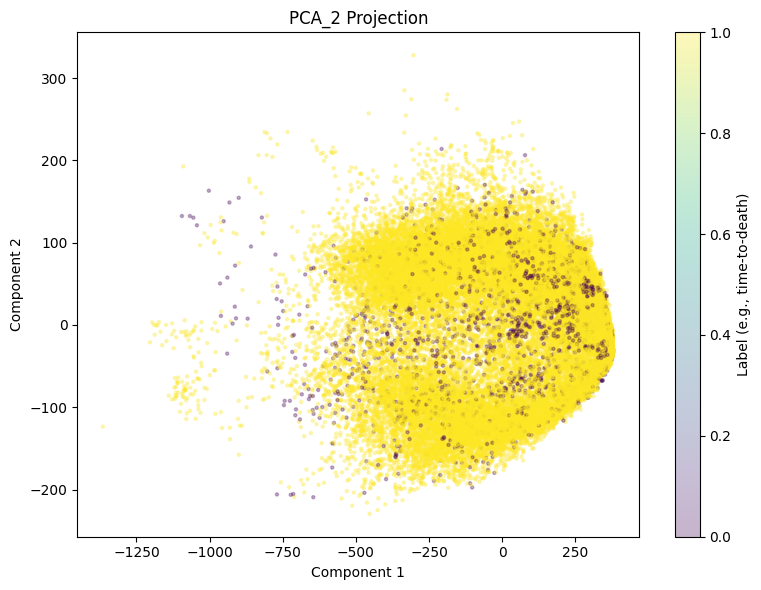

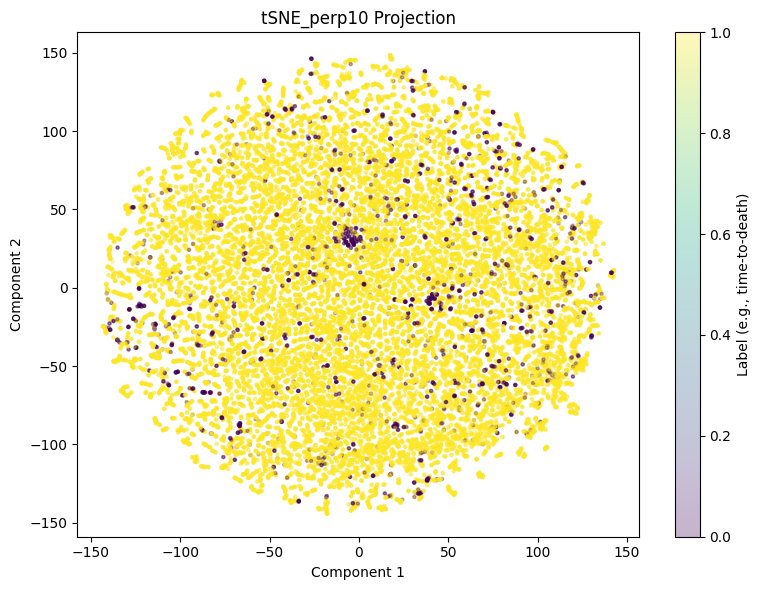

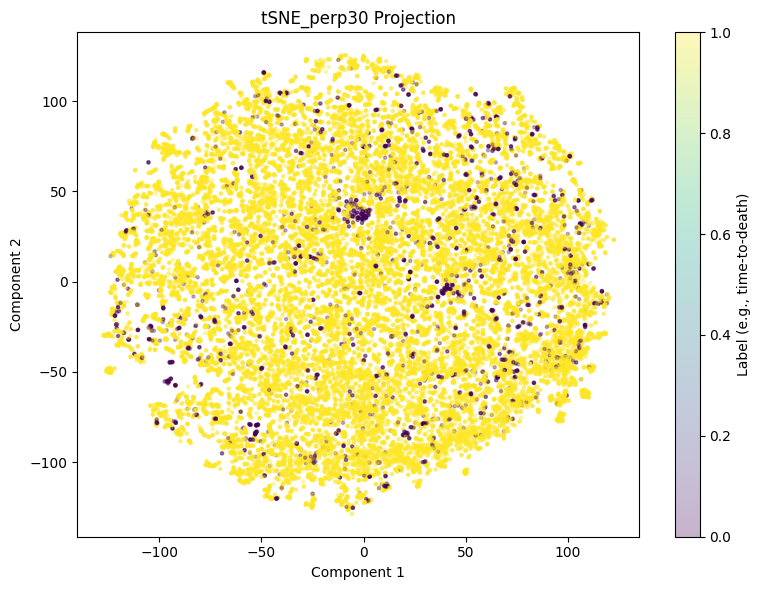

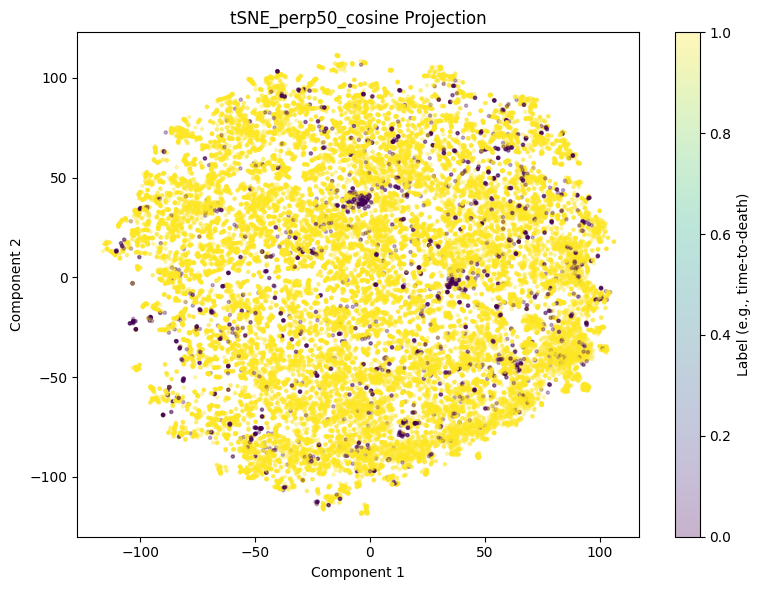

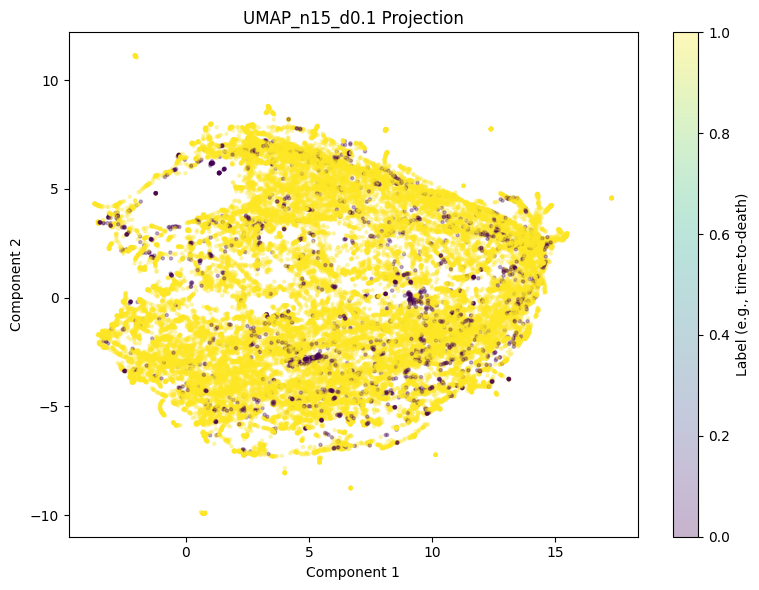

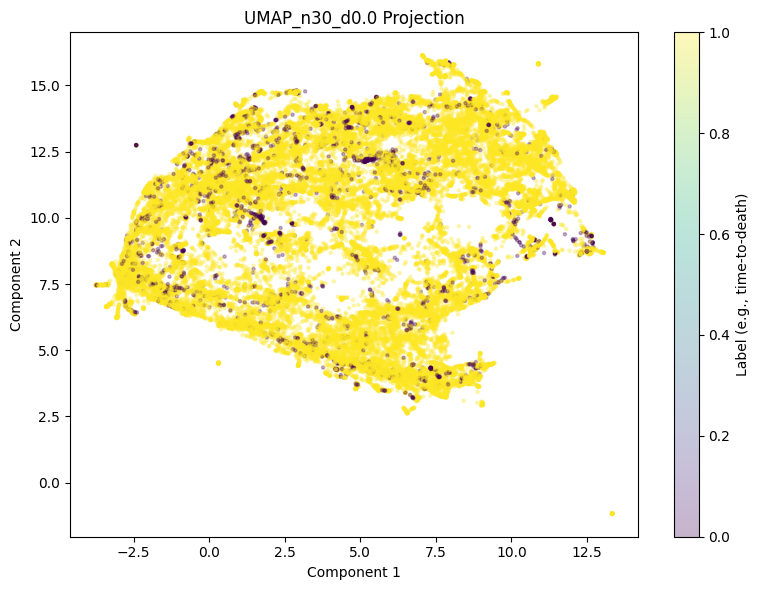

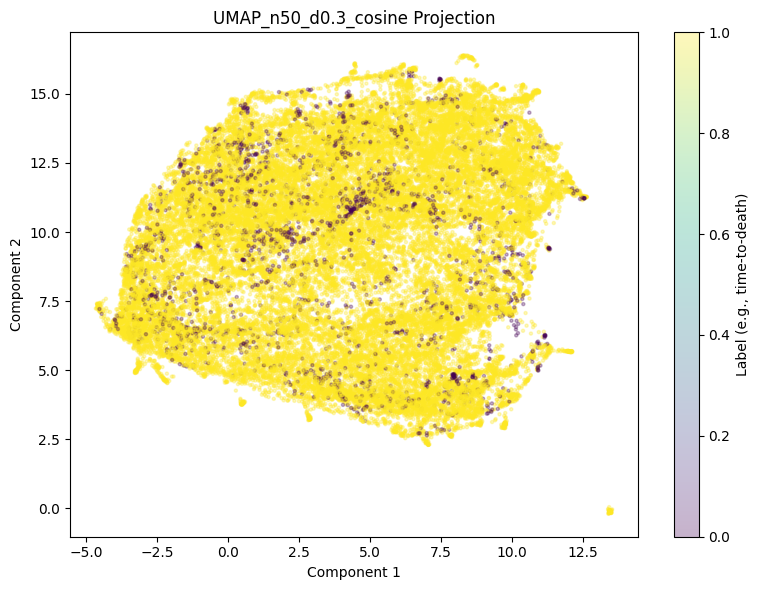

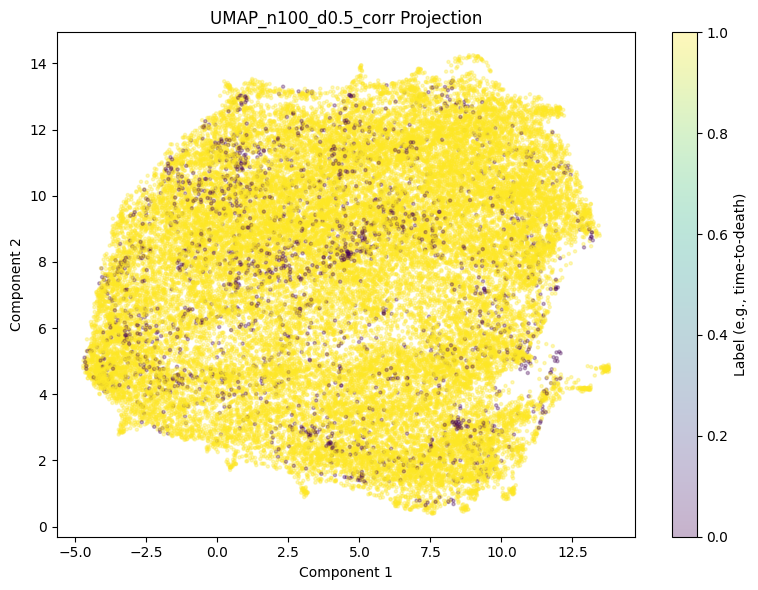

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

# Normalize label range for consistent coloring
#norm = plt.Normalize(vmin=labels.min(), vmax=labels.max())
cmap = plt.cm.viridis  # or 'plasma', 'inferno', etc.

for i, (name, reduced) in enumerate(reduced_results.items()):
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(
        reduced[:, 0], reduced[:, 1],
        c=labels,
        cmap=cmap,
        #norm=norm,
        s=5,
        alpha=0.3
    )
    plt.colorbar(sc, label="Label (e.g., time-to-death)")
    plt.title(f"{name} Projection")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    # plt.savefig(f"{name.lower()}_projection_gradient.png", dpi=300)
    plt.show()

/tmp/ipykernel_3029976/637437667.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


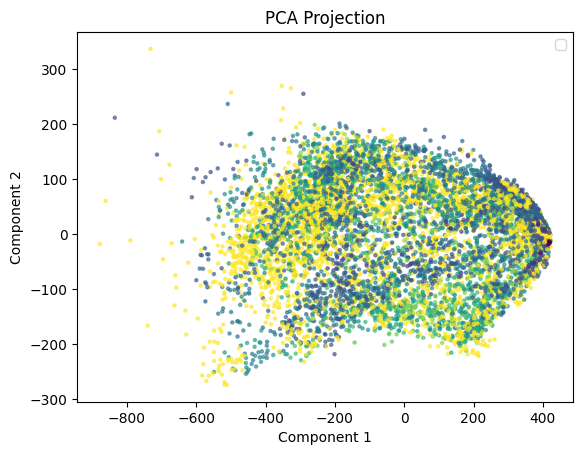

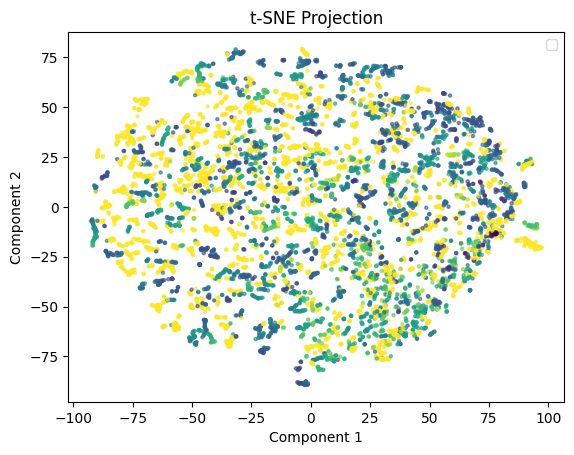

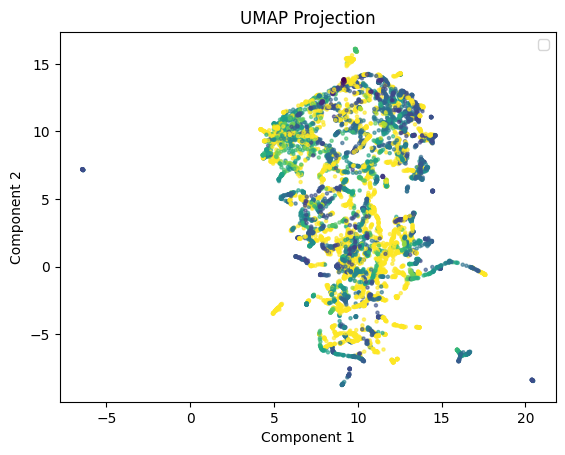

In [20]:
# === Plotting ===
for i, (name, reduced) in enumerate(reduced_results.items()):
    plt.scatter(reduced[:, 0], reduced[:, 1], s=5, alpha=0.6, c=labels, cmap='viridis')
    plt.title(f"{name} Projection")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.show()

In [ ]:
# # ========== Save ==========
# embeddings = np.concatenate(all_embeddings, axis=0)
# labels = np.concatenate(all_labels, axis=0) if all_labels else None

# save_path.parent.mkdir(parents=True, exist_ok=True)

# if labels is not None:
#     np.savez_compressed(save_path, embeddings=embeddings, labels=labels)
#     print(f"Saved embeddings and labels to {save_path}")
# else:
#     np.save(save_path, embeddings)
#     print(f"Saved embeddings to {save_path}")